In [2]:
# Create a plot showing the request with the time window
function plot_Request_Time_Window(passengers)
    figure();
    request_no = length(passengers)
    drop_time_list = []

    for i=1:request_no
        p = passengers[i]
        drop_time = p.pickup_time+p.duration
        push!(drop_time_list, drop_time)
        
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        hlines(y=i, xmin=p.pickup_time, xmax=drop_time, color=color_val)
        plot(p.pickup_time, i, marker="o", color=color_val)
        plot(drop_time, i, marker="o", color=color_val)
        
        time_stamp = string("T = ", p.pickup_time)
        text(p.pickup_time, i + 0.1, time_stamp, fontsize=8)
        time_stamp = string("T = ", drop_time)
        text(drop_time, i - 0.2, time_stamp, fontsize=8) 
    end

    PyPlot.yticks(1:request_no)
    ax = gca()
    ax[:set_xlim](passengers[1].pickup_time - 10, maximum(drop_time_list) + 20)
    ax[:set_ylim]([0, request_no + 1])
    title("Request vs Time")
    xlabel("Time")
    ylabel("Request #")
    grid("on")
end

plot_Request_Time_Window (generic function with 1 method)

In [12]:
using PyPlot
WIDTH = 51 # odd number
HEIGHT = 41 # odd number
NRG = min(WIDTH, HEIGHT)

type Passenger
    pickup_pos::Tuple{Int64, Int64}
    pickup_time::Int
    dropoff_pos::Tuple{Int64, Int64}
    duration::Int
end
type Driver
    cur_pos::Tuple{Int64, Int64}
end


function rand_xy()
   return (rand(1:WIDTH), rand(1:HEIGHT)) 
end


function rand_normalized_xy()
    pass_x = Int(round((randn()/6+0.5)*(NRG-1)+1))
    pass_y = Int(round((randn()/6+0.5)*(NRG-1)+1))
    if WIDTH > HEIGHT
        pass_x += Int(round((WIDTH-HEIGHT)/2))
    else
        pass_y += Int(round((HEIGHT-WIDTH)/2))
    end
    return (pass_x, pass_y)
end


genGrid (generic function with 1 method)

In [ ]:
function plot_passenger_driver(passengers, drivers)
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[] # driver current position x
    dys = Int64[] # driver current position y
    fig = figure("pyplot_scatterplot",figsize=(15,15) )#(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(passengers)
        p = passengers[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.3)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.3)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(drivers)
        d = drivers[i]
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="r")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="g")
    scatter(dxs,dys,s=300,alpha=0.5,color="b")
    
    title("Map")
    xlabel("X");xlim([1,WIDTH])
    ylabel("Y");ylim([1,HEIGHT])
    grid("on")
end


In [ ]:
function genGrid(n_passenger, n_driver)
    passengers = Passenger[]
    drivers = Driver[]
    ptime = sort(rand(50:200,n_passenger))
    for i=1:n_passenger
        ppos = rand_xy()
        dpos = rand_xy()
        p = Passenger(ppos, ptime[i], dpos, manhattan_distance(ppos,dpos))
        push!(passengers, p)
    end
    for i=1:n_driver
        d = Driver((Int((WIDTH+1)/2), Int((HEIGHT+1)/2)))
        push!(drivers, d)
    end
    plot_passenger_driver(passengers, drivers)
    for p in passengers
        println(p)
    end
    plot_Request_Time_Window(passengers)
    return passengers,drivers
end

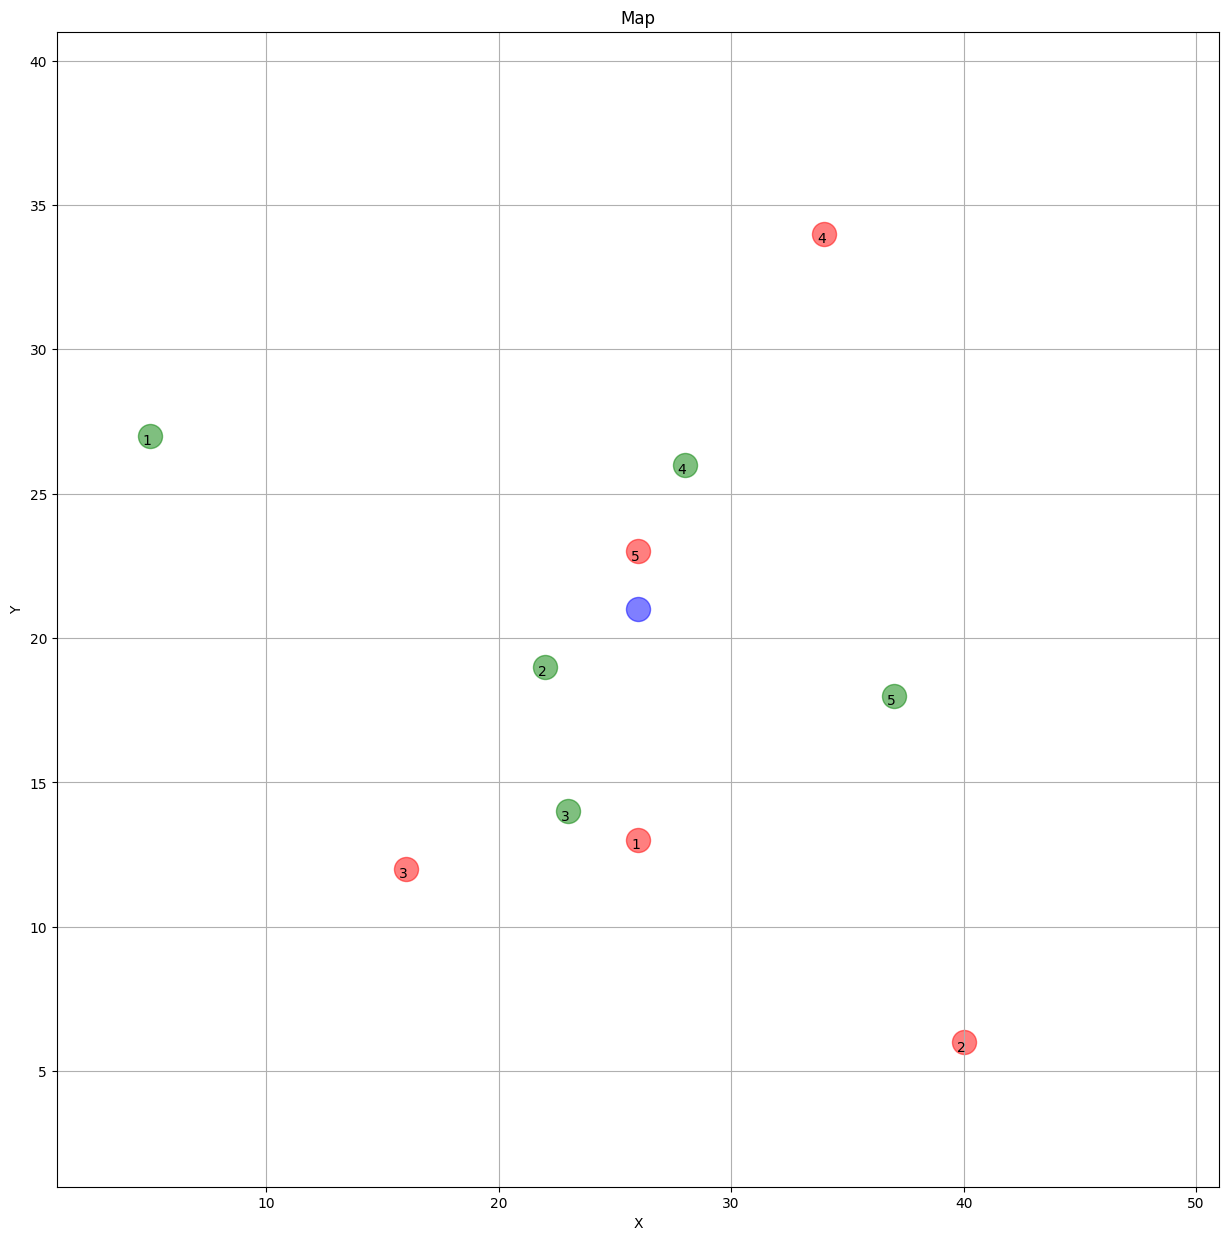

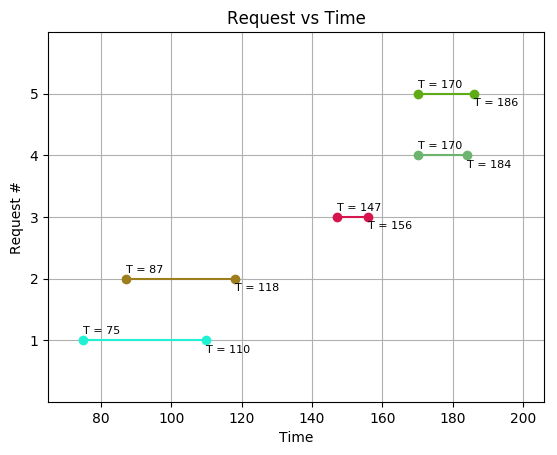

Passenger((26, 13), 75, (5, 27), 35)
Passenger((40, 6), 87, (22, 19), 31)
Passenger((16, 12), 147, (23, 14), 9)
Passenger((34, 34), 170, (28, 26), 14)
Passenger((26, 23), 170, (37, 18), 16)


(Passenger[Passenger((26, 13), 75, (5, 27), 35), Passenger((40, 6), 87, (22, 19), 31), Passenger((16, 12), 147, (23, 14), 9), Passenger((34, 34), 170, (28, 26), 14), Passenger((26, 23), 170, (37, 18), 16)], Driver[Driver((26, 21))])

In [91]:
requests, depot = genGrid(5,1)

In [106]:
# Get the coordinates of all pickup, drop and depot locations
print(depot)
nodes = []
for d in depot
    depot_node = d.cur_pos
    push!(nodes, depot_node)
end

for r in requests
    push!(nodes, r.pickup_pos)
    push!(nodes, r.dropoff_pos)
end
nodes

Driver[Driver((26, 21))]

11-element Array{Any,1}:
 (26, 21)
 (26, 13)
 (5, 27) 
 (40, 6) 
 (22, 19)
 (16, 12)
 (23, 14)
 (34, 34)
 (28, 26)
 (26, 23)
 (37, 18)

# Generating distance matrix 

In [107]:
# Generating distance matrix.

# Creating names for nodes
numReq = length(requests)
points = []
i = 0
push!(points,"Depot")
for r in 1:numReq
    i = i+1
    pickup = string("P_",i)
    drop = string("D_",i)
    push!(points,pickup)
    push!(points,drop)
end
println(points)

# Compute distance matrix for the Agencies
pointA = nodes
pointB = copy(nodes)

nodeLen = length(nodes) # nodes include pickup, dropoff and depot

D = zeros(nodeLen,nodeLen)

for j = 1:nodeLen
        for i = 1:nodeLen
            D[i, j] = abs(pointA[j][1] - pointB[i][1]) + abs(pointA[j][2] - pointB[i][2])
        end
end
#println("Distance matrix : ",D)
println("")

using NamedArrays
dist_matrix =  NamedArray(D,(points,points),("From","To"))
show(IOContext(STDOUT, displaysize=(2000, 2000)), dist_matrix)


Any["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3", "P_4", "D_4", "P_5", "D_5"]

11×11 Named Array{Float64,2}
From ╲ To │ Depot    P_1    D_1    P_2    D_2    P_3    D_3    P_4    D_4    P_5    D_5
──────────┼────────────────────────────────────────────────────────────────────────────
Depot     │   0.0    8.0   27.0   29.0    6.0   19.0   10.0   21.0    7.0    2.0   14.0
P_1       │   8.0    0.0   35.0   21.0   10.0   11.0    4.0   29.0   15.0   10.0   16.0
D_1       │  27.0   35.0    0.0   56.0   25.0   26.0   31.0   36.0   24.0   25.0   41.0
P_2       │  29.0   21.0   56.0    0.0   31.0   30.0   25.0   34.0   32.0   31.0   15.0
D_2       │   6.0   10.0   25.0   31.0    0.0   13.0    6.0   27.0   13.0    8.0   16.0
P_3       │  19.0   11.0   26.0   30.0   13.0    0.0    9.0   40.0   26.0   21.0   27.0
D_3       │  10.0    4.0   31.0   25.0    6.0    9.0    0.0   31.0   17.0   12.0   18.0
P_4       │  21.0   29.0   36.0   34.0   27.0   40.0   31.0    0.0   14.0   19.0   19.0
D_4    